In [1]:
#Import
# Imports here
%matplotlib inline
import time
import json
import os
import cv2
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from collections import OrderedDict
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [2]:
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')
from test_model_pytorch_facebook_challenge import publish_evaluated_model, calc_accuracy

In [3]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [4]:
#Loads the checkpoint

def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    pretrained_model = getattr(models, chpt['arch'])
    if callable(pretrained_model):
        model = pretrained_model(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture not recognized")
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.fc = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [5]:
data_dir = '.\\flower_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

dirs = {'train': train_dir, 
        'valid': valid_dir}

In [16]:
model = load_model('classifier.pth')
calc_accuracy(model, input_image_size=224, testset_path=valid_dir)

Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.8888888955116272
Mean accuracy: 0.9416399598121643


0.94163996

In [18]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns a Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [19]:
#Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)   

In [20]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [21]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [22]:
def plot_solution(image_path, model=model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    #flower_num = image_path.split('\\')[3]
    #title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img,ax)
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
    print("The flower belongs to the genus "+flowers[0])

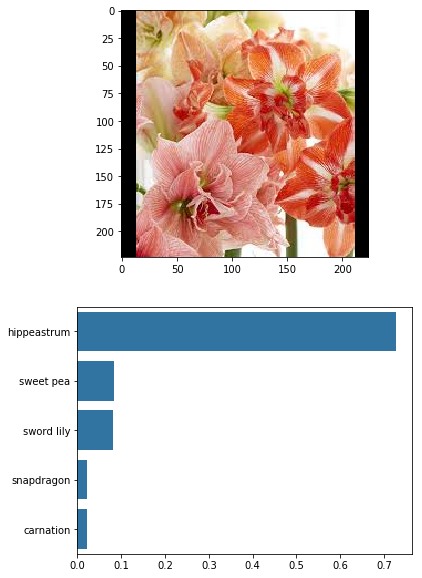

The flower belongs to the genus hippeastrum


In [28]:

image_path = r'D:\Files\Projects\Flower classifier\Samples\download.jpg'
plot_solution(image_path)